## ML project on predicting wine quality based on characteristics

This project 

#### Import datasets from S3 bucket and assign to Pandas DataFrames

In [1]:
import boto3

# Specify your S3 bucket name and the keys (paths) to the dataset files
bucket_name = 'wine-ml'
keys = ['winequality-white.csv', 'winequality-red.csv']  

# Create a Boto3 client for S3
s3_client = boto3.client('s3')

# Download each dataset file from S3
for i, key in enumerate(keys):
    local_filename = f'local_filename_{i}.csv'  # Generate unique local filename for each dataset
    s3_client.download_file(bucket_name, key, local_filename)


In [2]:
import pandas as pd

# Load the datasets into DataFrame objects
white_wine_df = pd.read_csv('local_filename_0.csv')
red_wine_df = pd.read_csv('local_filename_1.csv')


#### Split values into individual columns, as all are initially contained in one

In [3]:
white_wine_df = white_wine_df['fixed acidity;"volatile acidity";"citric acid";"residual sugar";"chlorides";"free sulfur dioxide";"total sulfur dioxide";"density";"pH";"sulphates";"alcohol";"quality"'].str.split(';', expand=True)
red_wine_df = red_wine_df['fixed acidity;"volatile acidity";"citric acid";"residual sugar";"chlorides";"free sulfur dioxide";"total sulfur dioxide";"density";"pH";"sulphates";"alcohol";"quality"'].str.split(';', expand=True)

#### Assign Column names to columns, as these are initially incorrect

In [4]:
# Define the correct column names
column_names = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
                'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
                'pH', 'sulphates', 'alcohol', 'quality']

# Rename the columns in each DataFrame
white_wine_df.columns = column_names
red_wine_df.columns = column_names

#### Create 'wine_type' column and concatenate into a single DataFrame

In [5]:
# Add a 'wine_type' column to distinguish between white and red wines
white_wine_df['wine_type'] = 'white'
red_wine_df['wine_type'] = 'red'

# Merge the datasets
merged_df = pd.concat([white_wine_df, red_wine_df], ignore_index=True)

In [ ]:
merged_df.shape

#### Convert all numerical columns to float

In [6]:
# Iterate over each column
for column in merged_df.columns:
    # Exclude the 'wine_type' column
    if column != 'wine_type':
        # Convert the values in each column from strings to floats
        merged_df[column] = merged_df[column].astype(float)


### Exploratory Data Analysis

#### Bar plot showing distribution of quality

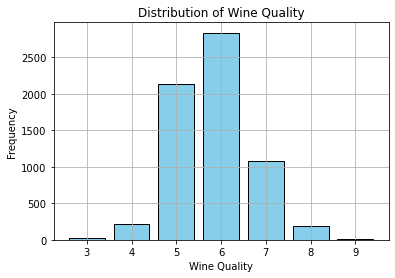

In [7]:
import matplotlib.pyplot as plt
value_counts = merged_df['quality'].value_counts().sort_index()
plt.bar(value_counts.index, value_counts.values, color='skyblue', edgecolor='black')
plt.xlabel('Wine Quality')
plt.ylabel('Frequency')
plt.title('Distribution of Wine Quality')
plt.grid(True)
plt.show()


#### Correlation heatmap between variables

In [8]:
# Drop non-numeric column'wine_type'
numeric_df = merged_df.drop(columns=['wine_type'])

# Create a correlation matrix
correlation_matrix = numeric_df.corr()

# Print or display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)


Correlation Matrix:
                      fixed acidity  volatile acidity  citric acid  \
fixed acidity              1.000000          0.219008     0.324436   
volatile acidity           0.219008          1.000000    -0.377981   
citric acid                0.324436         -0.377981     1.000000   
residual sugar            -0.111981         -0.196011     0.142451   
chlorides                  0.298195          0.377124     0.038998   
free sulfur dioxide       -0.282735         -0.352557     0.133126   
total sulfur dioxide      -0.329054         -0.414476     0.195242   
density                    0.458910          0.271296     0.096154   
pH                        -0.252700          0.261454    -0.329808   
sulphates                  0.299568          0.225984     0.056197   
alcohol                   -0.095452         -0.037640    -0.010493   
quality                   -0.076743         -0.265699     0.085532   

                      residual sugar  chlorides  free sulfur dioxide 

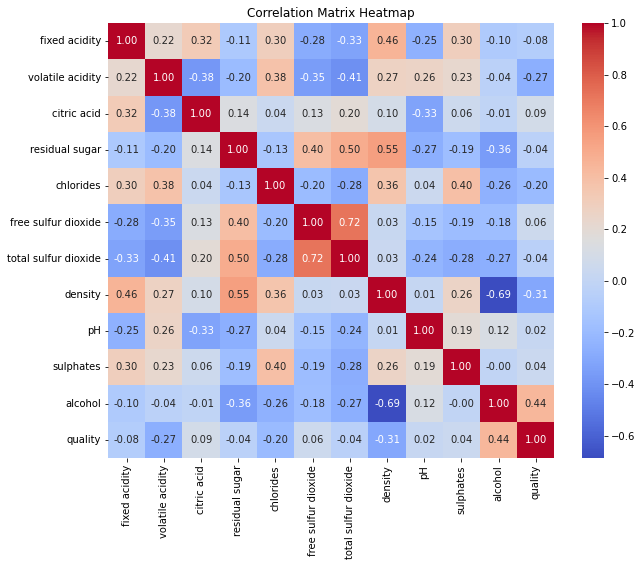

In [9]:
import seaborn as sns

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()


In [10]:
# Sort the correlations with 'quality' in descending order
quality_correlations = correlation_matrix['quality'].sort_values(ascending=False)

# Print or display the sorted correlations
print("Correlations with 'quality' (descending order):")
print(quality_correlations)

Correlations with 'quality' (descending order):
quality                 1.000000
alcohol                 0.444319
citric acid             0.085532
free sulfur dioxide     0.055463
sulphates               0.038485
pH                      0.019506
residual sugar         -0.036980
total sulfur dioxide   -0.041385
fixed acidity          -0.076743
chlorides              -0.200666
volatile acidity       -0.265699
density                -0.305858
Name: quality, dtype: float64


#### Outlier detection with boxplots

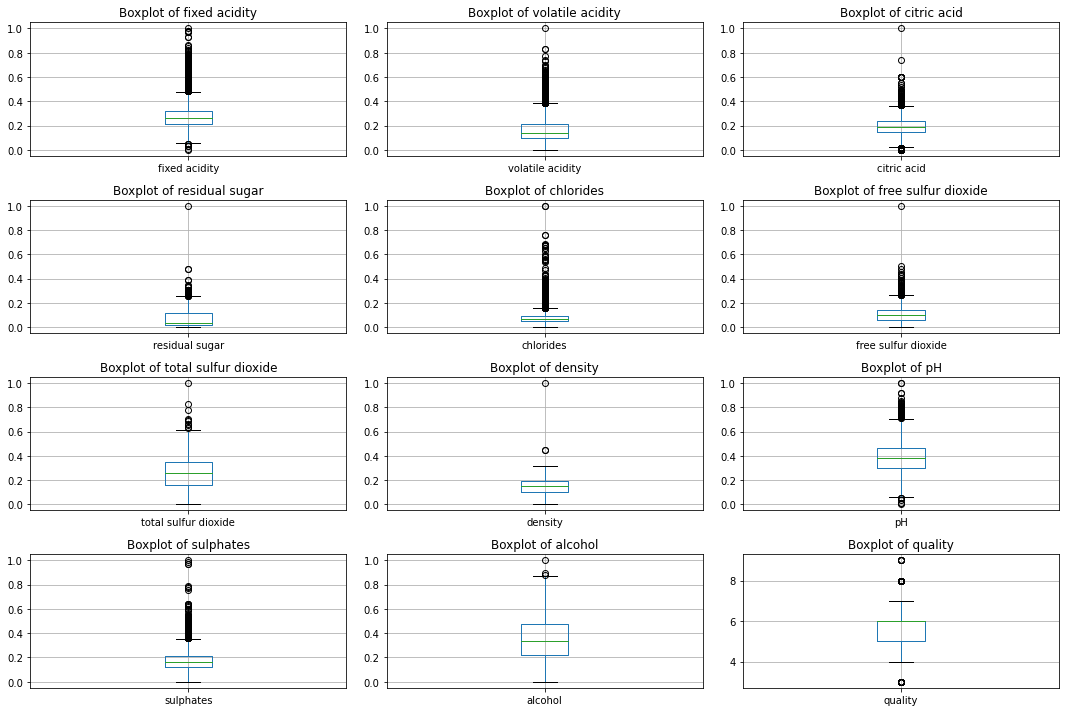

In [57]:
import math

num_cols = 3  
num_rows = math.ceil((len(merged_df.columns) - 1) / num_cols)  

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Flatten the axes
axes = axes.flatten()

# Create a boxplot for each variable
for i, column in enumerate(merged_df.columns):
    if column != 'wine_type':
        merged_df.boxplot(column=[column], ax=axes[i])
        axes[i].set_title(f'Boxplot of {column}')

# Hide any extra subplots
for j in range(num_rows * num_cols, len(axes)):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


There are a large number of potential outliers, so removing them is not feasible. The analysis will proceed as normal but these may impeed accurate predictions

In [12]:
import numpy as np

# Select numerical columns for outlier detection
numerical_columns = merged_df.select_dtypes(include=[np.number]).columns

# Calculate the interquartile range (IQR) for each variable
Q1 = merged_df[numerical_columns].quantile(0.25)
Q3 = merged_df[numerical_columns].quantile(0.75)
IQR = Q3 - Q1

# Define the upper and lower bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify potential outliers
potential_outliers = ((merged_df[numerical_columns] < lower_bound) | (merged_df[numerical_columns] > upper_bound))

# Filter the DataFrame to display potential outliers
outliers_df = merged_df[potential_outliers.any(axis=1)]

# Count potential outliers for each variable
outlier_counts = potential_outliers.sum()

# Print the count of potential outliers for each variable
print("Count of Potential Outliers for Each Variable:")
print(outlier_counts)

# Calculate and print the total count of potential outliers
total_outliers = outlier_counts.sum()
print("\nTotal Count of Potential Outliers:", total_outliers)

Count of Potential Outliers for Each Variable:
fixed acidity           357
volatile acidity        377
citric acid             509
residual sugar          118
chlorides               286
free sulfur dioxide      62
total sulfur dioxide     10
density                   3
pH                       73
sulphates               191
alcohol                   3
quality                 228
dtype: int64

Total Count of Potential Outliers: 2217


#### Scale the numerical attributes to be between 0 and 1

Scaling is performed as many ML models are sensitive to scale; different scales can affect the performance and convergence of optimisation algorithms, leading to suboptimal results or slower training times.

In [13]:
from sklearn.preprocessing import MinMaxScaler

# List of numerical columns excluding the target variable (quality)
numerical_columns = merged_df.select_dtypes(include=[np.number]).drop(columns=['quality']).columns

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler to the data and transform the numerical columns
merged_df[numerical_columns] = scaler.fit_transform(merged_df[numerical_columns])

In [14]:
merged_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,0.264463,0.126667,0.216867,0.308282,0.059801,0.152778,0.377880,0.267785,0.217054,0.129213,0.115942,6.0,white
1,0.206612,0.146667,0.204819,0.015337,0.066445,0.045139,0.290323,0.132832,0.449612,0.151685,0.217391,6.0,white
2,0.355372,0.133333,0.240964,0.096626,0.068106,0.100694,0.209677,0.154039,0.418605,0.123596,0.304348,6.0,white
3,0.280992,0.100000,0.192771,0.121166,0.081395,0.159722,0.414747,0.163678,0.364341,0.101124,0.275362,6.0,white
4,0.280992,0.100000,0.192771,0.121166,0.081395,0.159722,0.414747,0.163678,0.364341,0.101124,0.275362,6.0,white


#### One-hot encode 'wine_type' to create boolean columns for white wine and red wine

In [15]:
# ANNs require numerical input features so encoding the 'wine_type' variable is essential

encoded_df = pd.get_dummies(data=merged_df, columns=['wine_type'])
# Convert only the one-hot encoded columns to integers
encoded_df[['wine_type_white', 'wine_type_red']] = encoded_df[['wine_type_white', 'wine_type_red']].astype(int)

#### Move target variable (quality) to the front and split dataset into training, validation and test sets

SageMaker assumes the target variable (quality) is the first column, so it is moved

In [16]:
# Extract the 'quality' column
quality_column = encoded_df['quality']

# Drop the 'quality' column from the DataFrame
encoded_df.drop(columns=['quality'], inplace=True)

# Add the 'quality' column back at the front
encoded_df.insert(0, 'quality', quality_column)

from sklearn.model_selection import train_test_split

# Split data into training and the rest
train_data, temp_data = train_test_split(encoded_df, test_size=0.3, random_state=42)

# Split the rest into validation and test sets
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Print the shapes of the resulting datasets
print("Training data shape:", train_data.shape)
print("Validation data shape:", validation_data.shape)
print("Test data shape:", test_data.shape)

Training data shape: (4547, 14)
Validation data shape: (975, 14)
Test data shape: (975, 14)


In [ ]:
encoded_df.head()

#### Convert datasets to CSV format and upload to S3 bucket

In [17]:
import io

# Convert the dataframes to CSV format in memory
train_data_buffer = io.StringIO()
train_data.to_csv(train_data_buffer, index=False)
train_data_buffer.seek(0)

validation_data_buffer = io.StringIO()
validation_data.to_csv(validation_data_buffer, index=False)
validation_data_buffer.seek(0)

test_data_buffer = io.StringIO()
test_data.to_csv(test_data_buffer, index=False)
test_data_buffer.seek(0)

# Upload the CSV data to S3
s3_client.put_object(Body=train_data_buffer.getvalue(), Bucket=bucket_name, Key='train_data.csv')
s3_client.put_object(Body=validation_data_buffer.getvalue(), Bucket=bucket_name, Key='validation_data.csv')
s3_client.put_object(Body=test_data_buffer.getvalue(), Bucket=bucket_name, Key='test_data.csv')

{'ResponseMetadata': {'RequestId': 'A2EFRWFHATKF80TA',
  'HostId': 'CehK8+kv9qSKCdRYmN4rwFsZRn6KDZO0W8HuAcyL98JjDzHSnGustMg8tayEpva7E+no4VEfHpA=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'CehK8+kv9qSKCdRYmN4rwFsZRn6KDZO0W8HuAcyL98JjDzHSnGustMg8tayEpva7E+no4VEfHpA=',
   'x-amz-request-id': 'A2EFRWFHATKF80TA',
   'date': 'Thu, 14 Mar 2024 04:32:19 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"d5595f9b056670def7a925d6955aa85c"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"d5595f9b056670def7a925d6955aa85c"',
 'ServerSideEncryption': 'AES256'}

## Machine Learning Model Construction, Training, and Evaluation

#### Set up SageMaker XGBoost training job

In [ ]:
import sagemaker
from sagemaker.inputs import TrainingInput
from sagemaker import get_execution_role
from sagemaker.tuner import HyperparameterTuner, IntegerParameter, ContinuousParameter

# Define your SageMaker execution role
role = get_execution_role()

# Specify the S3 bucket and prefix where you saved the training, validation, and test data
bucket_name = 'wine-ml'

# Define the paths to the training, validation, and test data in S3
train_data_path = f's3://{bucket_name}/train_data.csv'
validation_data_path = f's3://{bucket_name}/validation_data.csv'
test_data_path = f's3://{bucket_name}/test_data.csv'

# Define the SageMaker XGBoost estimator
xgb_estimator = sagemaker.estimator.Estimator(
    image_uri=sagemaker.image_uris.retrieve("xgboost", region=sagemaker.Session().boto_region_name, version='1.2-1'),
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    output_path=f's3://{bucket_name}/optimised_xgboost_output',
    deploy_mode=False  # Disable automatic model deployment
)

# Define the hyperparameter ranges for tuning
hyperparameter_ranges = {
    'max_depth': IntegerParameter(4, 7),
    'eta': ContinuousParameter(0.1, 0.4),
    'gamma': ContinuousParameter(0.0, 0.3),
    'min_child_weight': IntegerParameter(1, 5),
    'subsample': ContinuousParameter(0.5, 1),
    'alpha': ContinuousParameter(0, 0.1),
    'lambda': ContinuousParameter(0, 0.1),
    'num_round': IntegerParameter(100,101)
}

# Define the objective metric to optimize
objective_metric_name = 'validation:rmse'

# Define the hyperparameter tuner
tuner = HyperparameterTuner(
    estimator=xgb_estimator,
    objective_metric_name=objective_metric_name,
    objective_type='Minimize',  
    hyperparameter_ranges=hyperparameter_ranges,
    max_jobs=28,  # Maximum number of tuning jobs
    max_parallel_jobs=4  # Number of tuning jobs that run in parallel
)


# Define the input channels for training
train_input = TrainingInput(train_data_path, content_type='text/csv')
validation_input = TrainingInput(validation_data_path, content_type='text/csv')

# Launch the hyperparameter tuning job
tuner.fit({'train': train_input, 'validation': validation_input})

# Stop the hyperparameter tuning job
tuner.stop_tuning_job()

#### Access the training job with the lowest validation RMSE and extract the associated hyper-parameter set

In [ ]:
# Get the name of the best training job
best_training_job_name = tuner.best_training_job()

# Describe the best training job to obtain the hyperparameters
best_training_job_info = sagemaker.Session().describe_training_job(job_name=best_training_job_name)
best_hyperparameters = best_training_job_info['HyperParameters']

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_hyperparameters)

#### Train final model with optimal hyper-parameters

In [18]:
# Set the best hyperparameters in the XGBoost estimator
xgb_estimator.set_hyperparameters(**best_hyperparameters)

# Train a model using the best hyperparameters and save it as 'xgboost_optimal'
xgb_estimator.fit({'train': train_input, 'validation': validation_input}, job_name='xgboost-optimal')

NameError: name 'xgb_estimator' is not defined

#### Use trained model on test set

The trained model is retrieved from the S3 bucket and placed into the same folder as the notebook file

In [22]:
import pickle
import xgboost as xgb

# Load the model from the local file
with open('xgboost-model', 'rb') as file:
    xgboost_model = pickle.load(file)

# Extract features and labels from the test dataset
X_test_xgb = test_data.drop(columns=['quality'])
y_test_xgb = test_data['quality']

# Convert the test data DataFrame to a DMatrix object
dtest_xgb = xgb.DMatrix(X_test_xgb)

# Make predictions on the test set using XGBoost
predictions_xgboost = xgboost_model.predict(dtest_xgb)
predictions_xgboost_rounded = np.round(predictions_xgboost)

#### Evaluation metrics

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


# Calculate evaluation metrics for XGBoost
xgboost_metrics = {
    'MSE (XGBoost)': mean_squared_error(y_test_xgb, predictions_xgboost_rounded),
    'MAE (XGBoost)': mean_absolute_error(y_test_xgb, predictions_xgboost_rounded),
    'RMSE (XGBoost)': np.sqrt(mean_squared_error(y_test_xgb, predictions_xgboost_rounded)),
    'R2 (XGBoost)': r2_score(y_test_xgb, predictions_xgboost_rounded)
}

print(xgboost_metrics)

{'MSE (XGBoost)': 0.47794871794871796, 'MAE (XGBoost)': 0.4246153846153846, 'RMSE (XGBoost)': 0.6913383527251457, 'R2 (XGBoost)': 0.35939372576665496}


In [25]:
# Create a DataFrame with actual and predicted values
xgboost_results_df = pd.DataFrame({'Actual': y_test_xgb, 'Predicted': predictions_xgboost_rounded})
xgboost_results_df.head()

,Actual,Predicted
4221,6.0,7.0
4500,6.0,6.0
5589,5.0,5.0
2629,5.0,5.0
3410,7.0,6.0


#### Scatter plot of actual vs predicted values for quality

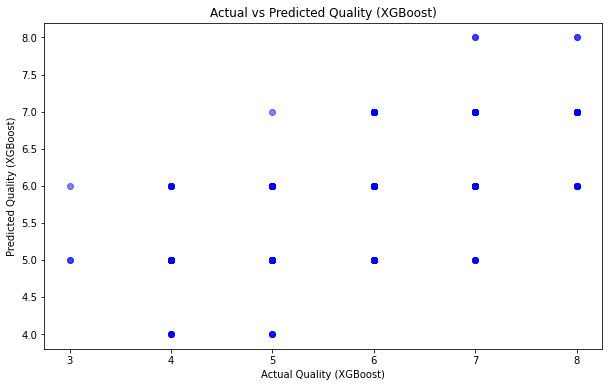

In [26]:
# Plot predicted vs actual quality for XGBoost
plt.figure(figsize=(10, 6))
plt.scatter(y_test_xgb, predictions_xgboost_rounded, color='blue', alpha=0.5)
plt.xlabel('Actual Quality (XGBoost)')
plt.ylabel('Predicted Quality (XGBoost)')
plt.title('Actual vs Predicted Quality (XGBoost)')
plt.show()

These results are suboptimal; R2 of 0.36 means that the XGBoost model explains only 36% of the variance in quality, indicating that the model's predictive power is limited and there is room for improvement. A feed-forward ANN will be constructed and the results will be compared.

#### FF-ANN construction

The data is already prepared so a ANN can be easily constructed. A simple structure will be used first, and from there it can be adjusted depending on the results. Weak L2 regularisation is applied to prevent over-fitting, as well as 10% dropout.

In [45]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2


y_train_ff_ann = train_data['quality']
X_train_ff_ann = train_data.drop(columns=['quality'])

y_test_ff_ann = test_data['quality']
X_test_ff_ann = test_data.drop(columns=['quality'])

input_shape_ff_ann = X_train_ff_ann.shape[1]

model_ff_ann = Sequential()
model_ff_ann.add(Dense(units=input_shape_ff_ann, activation='relu', input_shape=(input_shape_ff_ann,)))
model_ff_ann.add(Dropout(0.1))
model_ff_ann.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
model_ff_ann.add(Dropout(0.1))
model_ff_ann.add(Dense(8, activation='relu', kernel_regularizer=l2(0.01)))
model_ff_ann.add(Dropout(0.1))
model_ff_ann.add(Dense(units=1, activation='linear'))

model_ff_ann.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])  # Mean squared error loss for regression
model_ff_ann.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 13)                182       
                                                                 
 dropout_10 (Dropout)        (None, 13)                0         
                                                                 
 dense_14 (Dense)            (None, 16)                224       
                                                                 
 dropout_11 (Dropout)        (None, 16)                0         
                                                                 
 dense_15 (Dense)            (None, 8)                 136       
                                                                 
 dropout_12 (Dropout)        (None, 8)                 0         
                                                                 
 dense_16 (Dense)            (None, 1)                

#### FF-ANN training

In [46]:
# Train the model using all data
history_ff_ann = model_ff_ann.fit(X_train_ff_ann, y_train_ff_ann, epochs=100, batch_size=2, verbose=1)

Epoch 1/100
2274/2274 [==============================] - 5s 2ms/step - loss: 3.4836 - mae: 1.3394
Epoch 2/100
2274/2274 [==============================] - 4s 2ms/step - loss: 1.5414 - mae: 0.9376
Epoch 3/100
2274/2274 [==============================] - 4s 2ms/step - loss: 1.2939 - mae: 0.8593
Epoch 4/100
2274/2274 [==============================] - 4s 2ms/step - loss: 1.0998 - mae: 0.7993
Epoch 5/100
2274/2274 [==============================] - 4s 2ms/step - loss: 1.0300 - mae: 0.7672
Epoch 6/100
2274/2274 [==============================] - 4s 2ms/step - loss: 0.9372 - mae: 0.7345
Epoch 7/100
2274/2274 [==============================] - 4s 2ms/step - loss: 0.8805 - mae: 0.7165
Epoch 8/100
2274/2274 [==============================] - 5s 2ms/step - loss: 0.8584 - mae: 0.7070
Epoch 9/100
2274/2274 [==============================] - 4s 2ms/step - loss: 0.7978 - mae: 0.6855
Epoch 10/100
2274/2274 [==============================] - 4s 2ms/step - loss: 0.7844 - mae: 0.6737
Epoch 11/100
2274/2

In [47]:
# Evaluate FF-ANN model and calculate metrics
loss_ff_ann, mae_ff_ann = model_ff_ann.evaluate(X_test_ff_ann, y_test_ff_ann)
predictions_ff_ann = model_ff_ann.predict(X_test_ff_ann)
predictions_ff_ann_rounded = np.round(predictions_ff_ann)
rmse_ff_ann = np.sqrt(mean_squared_error(y_test_ff_ann, predictions_ff_ann_rounded))
r2_ff_ann = r2_score(y_test_ff_ann, predictions_ff_ann_rounded)

31/31 [==============================] - 0s 1ms/step


#### Loss over epochs

Here we see how loss (MSE) falls during training as the model converges to a solution

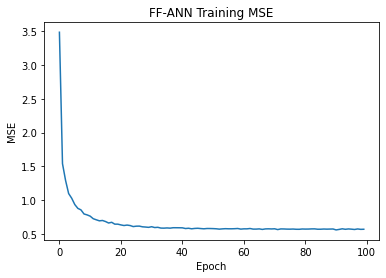

In [48]:
# Get the MSE values from the FF-ANN training history
train_loss_ff_ann = history_ff_ann.history['loss']

# Plot the FF-ANN MSE during training
plt.plot(train_loss_ff_ann)
plt.title('FF-ANN Training MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

#### FF-ANN performance metrics

In [49]:
# Print evaluation metrics for FF-ANN
print('MSE (FF-ANN) = ', loss_ff_ann)
print('MAE (FF-ANN) = ', mae_ff_ann)
print('RMSE (FF-ANN) = ', rmse_ff_ann)
print('R2 (FF-ANN) = ', r2_ff_ann)

MSE (FF-ANN) =  0.507889449596405
MAE (FF-ANN) =  0.5607770681381226
RMSE (FF-ANN) =  0.7726079710455211
R2 (FF-ANN) =  0.19992950299612267


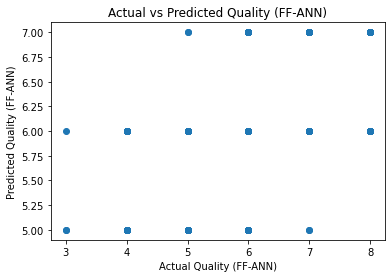

In [50]:
# Plot actual vs predicted for FF-ANN
plt.scatter(y_test_ff_ann, predictions_ff_ann_rounded)
plt.xlabel('Actual Quality (FF-ANN)')
plt.ylabel('Predicted Quality (FF-ANN)')
plt.title('Actual vs Predicted Quality (FF-ANN)')
plt.show()

In [51]:
# Create a DataFrame with actual and predicted values for FF-ANN
results_df_ff_ann = pd.DataFrame({'Actual': y_test_ff_ann.values.flatten(), 'Predicted': predictions_ff_ann_rounded.flatten()})

# Display the DataFrame for FF-ANN
results_df_ff_ann.tail()

,Actual,Predicted
970,6.0,5.0
971,5.0,6.0
972,5.0,6.0
973,6.0,6.0
974,7.0,6.0


In [52]:
# Create a DataFrame to store evaluation metrics for both models
evaluation_metrics = pd.DataFrame({
    'Metric': ['MSE', 'MAE', 'RMSE', 'R2'],
    'XGBoost': [xgboost_metrics['MSE (XGBoost)'], xgboost_metrics['MAE (XGBoost)'],
                xgboost_metrics['RMSE (XGBoost)'], xgboost_metrics['R2 (XGBoost)']],
    'FF-ANN': [loss_ff_ann, mae_ff_ann, rmse_ff_ann, r2_ff_ann]
})

# Display the DataFrame
print(evaluation_metrics)

  Metric   XGBoost    FF-ANN
0    MSE  0.477949  0.507889
1    MAE  0.424615  0.560777
2   RMSE  0.691338  0.772608
3     R2  0.359394  0.199930


With the chosen hyper-parameters and structures of both ML models, XGBoost slightly outperforms the FF-ANN, while also being much quicker to train.

Results are suboptimal for both models, suggesting they could not capture the complex relationships between wine characteristics and quality. Exploratory data analysis identified many potential outliers which were not removed due to the large proportion of them relative to the whole dataset, which may have hindered accurate prediction. 

Furthermore, while SageMaker searched for optimal hyper-parameters for XGBoost, it did not test every possible combination of every hyper-parameter due to resource constraints. Similarly, hyper-parameters for the FF-ANN were manually adjusted to increase performance but both models probably were not using optimal hyper-parameters.